In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving densed-64-64-64.npy to densed-64-64-64 (4).npy
User uploaded file "densed-64-64-64.npy" with length 2097280 bytes


In [0]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # 10 x 10 inches plot

In [0]:
r = np.load('densed-64-64-64 (4).npy')
ro  = 1e-5 + 1.24e-3*r - 2.83e-7*r*r + 2.79e-11*r*r*r
c = (ro + 0.112) * 1.38e-6

# тут не факт что все 1
t = 13
steps = 200
l = t / steps
h = 0.55e-6 # по приколу уменьшил
# h = 0.5e-6 # по приколу уменьшил
# h = 1 # по приколу уменьшил

# h = 1 # dx = dy = dz

K = l / h * c
K2 = K**2
K_2_by_3 = K**2 / 3


# initial conditions
P_pp = np.zeros_like(ro) # previous previous t - 2
P_p  = np.zeros_like(ro) # previous          t - 1
P    = np.zeros_like(ro) # current           t

In [0]:
def P_step(P_pp, P_p):
    '''
    mb work with flat and then reshape in return
    norm by now, mb add some more optimisations in future, also cuda
    '''

    S = P_p.shape[0]
    N = P_p.shape[1]

    P[2:-2, 2:-2, 2:-2] = 2 * P_p[2:-2, 2:-2, 2:-2] - P_pp[2:-2, 2:-2, 2:-2]

    Z = np.zeros_like(P_p)
    Z[2:-2, 2:-2, 2:-2] = 22.5 * P_p[2:-2, 2:-2, 2:-2]
    
    cell_indeces_flat = np.arange(S * N * N).reshape(S, N, N)[2:-2, 2:-2, 2:-2].flatten().reshape(-1, 1) # vertical vector

    s1_indexes_flat = cell_indeces_flat + np.array([-1, 1, -N, N, -N**2, N**2])      # i±1 j±1 k±1 
    s2_indexes_flat = cell_indeces_flat + np.array([-1, 1, -N, N, -N**2, N**2]) * 2  # i±2 j±2 k±2 
    s1_values = P_p.flatten()[s1_indexes_flat] # each row contains 6 neighbors of cell 
    s2_values = P_p.flatten()[s2_indexes_flat] # each row contains 6 neighbors of cell 
    s1 = np.sum(s1_values, axis=1) # sum by axis=1 is faster for default order
    s2 = np.sum(s2_values, axis=1)

    Z[2:-2, 2:-2, 2:-2] -=   4 * s1.reshape(S-4, N-4, N-4)
    Z[2:-2, 2:-2, 2:-2] += 1/4 * s2.reshape(S-4, N-4, N-4)

    m1 = np.array([1, -1, -1/8, -1/8])
    m2 = np.array([1, -1])

    s3_V_indexes = cell_indeces_flat + np.array([N**2, -N**2, 2*N**2, -2*N**2])
    s3_V_values = P_p.flatten()[s3_V_indexes] * m1 # po idee mozhno za skobki kak to vinesti m1 i m2
    s3_V_sum = np.sum(s3_V_values, axis=1)
    s3_N_indexes = cell_indeces_flat + np.array([N**2, -N**2])
    s3_N_values = ro.flatten()[s3_N_indexes] * m2
    s3_N_sum = np.sum(s3_N_values, axis=1)
    s3 = (s3_V_sum * s3_N_sum).reshape(S-4, N-4, N-4)
    
    s4_V_indexes = cell_indeces_flat + np.array([N, -N, 2*N, -2*N])
    s4_V_values = P_p.flatten()[s4_V_indexes] * m1
    s4_V_sum = np.sum(s4_V_values, axis=1)
    s4_N_indexes = cell_indeces_flat + np.array([N, -N])
    s4_N_values = ro.flatten()[s4_N_indexes] * m2
    s4_N_sum = np.sum(s4_N_values, axis=1)
    s4 = (s4_V_sum * s4_N_sum).reshape(S-4, N-4, N-4)

    s5_V_indexes = cell_indeces_flat + np.array([1, -1, 2, -2])
    s5_V_values = P_p.flatten()[s5_V_indexes] * m1
    s5_V_sum = np.sum(s5_V_values, axis=1)
    s5_N_indexes = cell_indeces_flat + np.array([1, -1])
    s5_N_values = ro.flatten()[s5_N_indexes] * m2
    s5_N_sum = np.sum(s5_N_values, axis=1)
    s5 = (s5_V_sum * s5_N_sum).reshape(S-4, N-4, N-4)
    
    Z[2:-2, 2:-2, 2:-2] += (s3 + s4 + s5) * ro[2:-2, 2:-2, 2:-2]
    P[2:-2, 2:-2, 2:-2] -= Z[2:-2, 2:-2, 2:-2] * K_2_by_3[2:-2, 2:-2, 2:-2]
    P[ro < 0.1] = 0
    return P

In [274]:
N = P.shape[1]

# steps = 100
img = np.zeros((steps, N))

A, B, C = 3, N//3, N//3 # sound source location

f = 400
T = np.linspace(0, 2, steps)
soundwave = np.sin(2 * np.pi * f * T)
propagated = np.zeros_like(soundwave)


for i, s in enumerate(soundwave):
    P_old = P
    
    P     = P_step(P_pp, P_p)
    P[A, B, C] = s
    propagated[i] = P[6, N//3, N//3] # location of 
#     print(propagated[i])
    print(f'\r{i}\t{propagated[i]}', end='')
#     print(P[-3])

    P_pp  = P_p
    P_p   = P_old
#     print(f'\r{i}', end='')

199	0.0017583059557907878

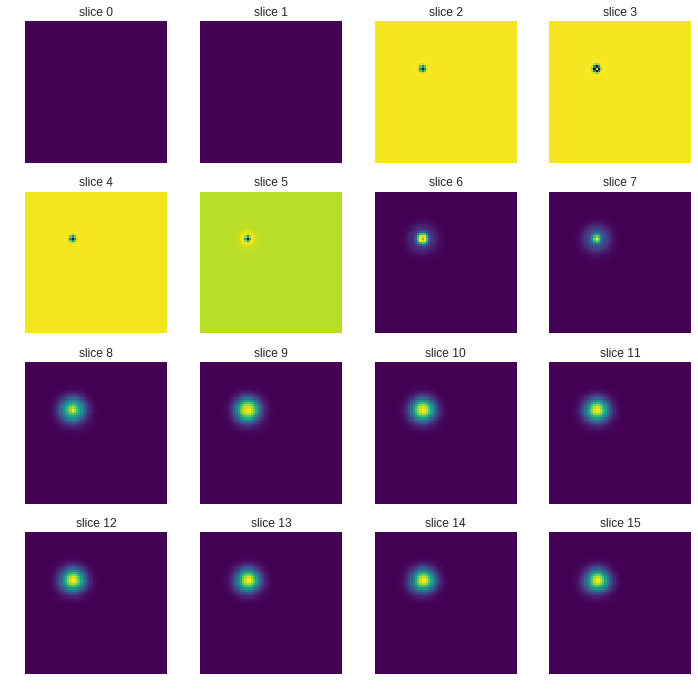

In [275]:
def sample_stack(stack, rows=4, cols=4, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='viridis')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(P)

In [0]:
plt.plot(P[:,N//2,N//2])
plt.plot(P[:,N//2,N//2-1])
plt.plot(P[:,N//2+1,N//2])
plt.show()

In [0]:
# plt.imshow(P[-4], cmap='viridis')
print(P[-10].mean())